# CMSC320 Final Project- Gas Prices and Transportation  
Names: Raghav Joshi, Akshay Karthik-Manimaran, Rohan Wadhwa, Anirudh Suresh


## Contributions

Raghav Joshi: Introduction, data cleaning/preprocessing, hypothesis testing #1, ML Algorithm design/development/training  
Akshay Karthik-Manimaran: Visualizations in introduction, hypothesis testing #2 and #3, conclusion  
Rohan Wadhwa: Project idea, outlier detection, ML algorithm analysis  
Anirudh Suresh: Neural Network, Visualization


## **Introduction**

Gas prices have become central to Americans’ everyday lives; being able to predict gas prices, or find a relation between gas prices and other data points can be extremely useful in many situations.

In this project, we will explore the relationship between gas prices and certain transportation related metrics. We will also see if either of these can be used to predict the other using machine learning or neural networks. One would assume that an increase in gas prices would lead to an increase in public transportation usage, this is one of the main things that we will explore with hypothesis testing.

Such questions are important to explore because it helps readers understand whether gas prices have such a profound effect on consumers that it changes their transportation habits. Answering this question can help policymakers decide on whether or not to expand public transportation options.

Fluctuations in gas prices are also indicative of the economy; looking at how changes in the economy influence transportation usage is critical to auto manufacturers and services like the metro, as it provides an insight of future revenue.

Conversely, an increase in public transportation usage could potentially cause a decrease in consumers causing gas prices to increase to maintain a profit. But this can in turn may as fewer people are driving their own vehicles, and thus buying their own gas.

Therefore, our goal is to find if a solid relationship between gas prices and transportation metrics exists, and see if either can predict the other. To do this, we found two datasets, one has various transportation metrics (136 to be exact), ranging from airline usage to rail employment; another just has gas prices. To keep this experiment understandable, we will not be using all of them, but instead we will choose a select few to gain a larger understanding.


## **Data Cleaning and Preprocessing**

We got the data from the following sites: https://www.kaggle.com/datasets/utkarshx27/monthly-transportation-statistics and https://www.kaggle.com/datasets/mruanova/us-gasoline-and-diesel-retail-prices-19952021

*Step 1: Identifying NaNs*

(588, 10)

Column:  Index ----- Number of NaN:  0
Column:  Date ----- Number of NaN:  0
Column:  U.S. Airline Traffic - Total - Seasonally Adjusted ----- Number of NaN:  521
Column:  Transit Ridership - Other Transit Modes - Adjusted ----- Number of NaN:  336
Column:  Transit Ridership - Fixed Route Bus - Adjusted ----- Number of NaN:  336
Column:  Transit Ridership - Urban Rail - Adjusted ----- Number of NaN:  336
Column:  Highway Fuel Price - Regular Gasoline ----- Number of NaN:  200
Column:  Passenger Rail Passengers ----- Number of NaN:  16
Column:  Passenger Rail Total Train Miles ----- Number of NaN:  16
Column:  Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted ----- Number of NaN:  501
Total NaN:  2262
Gas Prices Missing:   0


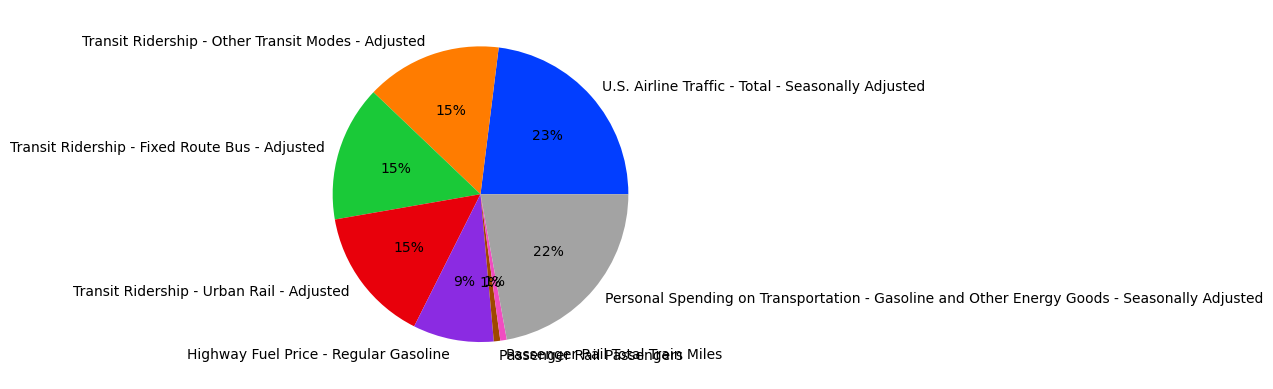

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from sklearn.impute import KNNImputer
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score


warnings.filterwarnings("ignore")

transportation_df = pd.read_csv('Monthly_Transportation_Statistics.csv')
gasprices_df = pd.read_csv('USGasanddieselprices.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

#Selecting the desired columns
transportation_df = transportation_df[['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']]
gasprices_df = gasprices_df[['Date', 'A1']]

#Converting to Datetime object
transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
transportation_df = transportation_df.loc[transportation_df['Date'] >= '01-01-1975']
display(transportation_df.shape)

#Observing the number of NaNs
total_nan = 0
for curr in range(0, len(transportation_df.columns)):
    print("Column: ", transportation_df.columns[curr] , "----- Number of NaN: ", transportation_df.iloc[:, curr].isnull().sum())
    total_nan += transportation_df.iloc[:, curr].isnull().sum()

print('Total NaN: ', total_nan)
print('Gas Prices Missing:  ', gasprices_df.loc[:, 'A1'].isnull().sum())

#Pie chart to show the distribution among the transportation
pie_df = transportation_df[['U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']]
colors = sns.color_palette('bright')[0:10]
plt.pie(x = pie_df.isna().sum(), labels = pie_df.isna().sum().index, colors = colors, autopct='%.0f%%')
plt.tight_layout()
plt.show()

*The two overlapping partitons represent Passenger Total Train Miles and Pasenger Rail Passengers. Both are 1% of the pie chart.*

Conclusion: We have two datasets, one is for transportation, another is for gas prices specifically. As the chart above demonstrates, there is a lot of data missing in the transportation dataframe especially from airline traffic and personal spending on transportation. Looking at the dataframes themselves, one can notice that for all missing data, the data is not missing after a certain date, meaning that the data is missing not at random (MNAR) because there is a clear time frame where the data is missing. In fact, none of the choosen columns have any data before 1975. The gas dataframe on the other hand, has no prices missing as we are using the "All Grades All Formulations Gasoline Prices" column only for simplicity. Features that are overrepresentative are Passenger Rail Passengers, Passenger Total Train Miles, and gas prices. This is because other feature are missing large portions of their data in this time frame. In addition, features that may be correlated are Highway Fuel Price and Personal Spending on Transportation.

We would like to explore if there is a correlation between gas prices and transit ridership. In this checkpoint, attributes that will be important are all froms of transit ridership and gas prices.

*Step 2: Removing NaNs*

In [122]:
gasprices_df.rename(columns={"A1": "Weekly Retail Gasoline Prices(All Grades Formulation)"}, inplace=True)
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
display(gasprices_df.head())

,Date,Weekly Retail Gasoline Prices(All Grades Formulation)
0,1995-01-02,1.127
1,1995-01-09,1.134
2,1995-01-16,1.126
3,1995-01-23,1.132
4,1995-01-30,1.131


The only column used from the gas prices csv file was renamed from "A1" to "Weekly Retail Gasoline Prices(All Grades Formulation)" to indicate what the column values represent.
The purpose of renaming not only serves as an indicator to people who view the gas prices csv but it also helps in making it clear what is being predicted during the ML model phase
of this project.

In [123]:
#List only the data columns that can be NaN (exclude 'Index' and 'Date')
cols = [
    'U.S. Airline Traffic - Total - Seasonally Adjusted',
    'Transit Ridership - Other Transit Modes - Adjusted',
    'Transit Ridership - Fixed Route Bus - Adjusted',
    'Transit Ridership - Urban Rail - Adjusted',
    'Highway Fuel Price - Regular Gasoline',
    'Passenger Rail Passengers',
    'Passenger Rail Total Train Miles',
    'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted'
]
print(transportation_df[cols].isna().sum())
print(transportation_df.shape)
print("\n")
# Drop rows where all specified columns are NaN
transportation_df = transportation_df.dropna(subset=cols, how='all')
print(transportation_df[cols].isna().sum())
print(transportation_df.shape)
#We will create a merged dataframe with the columns we want, first make a copy of our data
final_transportation_df = transportation_df.copy(deep = True)
final_gasprices_df = gasprices_df.copy(deep = True)
#Group the final gas prices so they appear by month and not week
final_gasprices_df = final_gasprices_df.groupby(pd.Grouper( key = 'Date', freq = 'ME')).agg({"Weekly Retail Gasoline Prices(All Grades Formulation)": 'mean'}).reset_index()
final_gasprices_df.set_index('Date', inplace = True)
final_transportation_df.set_index('Date', inplace = True)
#Merge the data frames
final_transportation_df.index = final_transportation_df.index.to_period('M')
final_gasprices_df.index = final_gasprices_df.index.to_period('M')
total_df = pd.merge( final_transportation_df, final_gasprices_df, on ='Date', how = 'outer')

display(total_df.head())

U.S. Airline Traffic - Total - Seasonally Adjusted                                             521
Transit Ridership - Other Transit Modes - Adjusted                                             336
Transit Ridership - Fixed Route Bus - Adjusted                                                 336
Transit Ridership - Urban Rail - Adjusted                                                      336
Highway Fuel Price - Regular Gasoline                                                          200
Passenger Rail Passengers                                                                       16
Passenger Rail Total Train Miles                                                                16
Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted    501
dtype: int64
(588, 10)


U.S. Airline Traffic - Total - Seasonally Adjusted                                             513
Transit Ridership - Other Transit Modes - Adjusted                                  

,Index,U.S. Airline Traffic - Total - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Passenger Rail Total Train Miles,Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted,Weekly Retail Gasoline Prices(All Grades Formulation)
Date,,,,,,,,,,
1975-01,336,NaN,NaN,NaN,NaN,NaN,0.0,4134425.0,NaN,NaN
1975-02,337,NaN,NaN,NaN,NaN,NaN,0.0,3600736.0,NaN,NaN
1975-03,338,NaN,NaN,NaN,NaN,NaN,0.0,4067192.0,NaN,NaN
1975-04,339,NaN,NaN,NaN,NaN,NaN,0.0,4000157.0,NaN,NaN
1975-05,340,NaN,NaN,NaN,NaN,NaN,0.0,4050197.0,NaN,NaN


We will keep total_df as a merged dataframe, but we will use the original data to observe the number of NaN and do some exploratory data analysis (hypothesis testing) in order to find patterns in the data. This will help us with outlier detection and keeping the gas prices data in weeks, which is important for hypothesis testing because gas prices often change weekly. 

When looking at the three transit columns, it can be noticed that the data only exists from 2002 to the end of 2022, causing many nan. To solve this, we will create a seperate dataframe just with the three columns.

In [124]:
# Checking for NaNs
transit_df = transportation_df[[ 'Date','Transit Ridership - Other Transit Modes - Adjusted',
    'Transit Ridership - Fixed Route Bus - Adjusted',
    'Transit Ridership - Urban Rail - Adjusted']]

transit_df = transit_df.loc[ '2002-01-01' <= transit_df['Date'], :]
transit_df = transit_df.loc[ transit_df['Date'] <= '2022-12-01', :]
print(transit_df.isnull().sum())
#display(transit_df.head())

Date                                                  0
Transit Ridership - Other Transit Modes - Adjusted    0
Transit Ridership - Fixed Route Bus - Adjusted        0
Transit Ridership - Urban Rail - Adjusted             0
dtype: int64


The dates for which all eight of those data columns are simultaneously missing will be dropped since they will not give us any information.

In [125]:
rail_cols = ['Passenger Rail Passengers', 'Passenger Rail Total Train Miles']
# Fill NaN values in the rail columns with forward and backward fill
transportation_df[rail_cols] = (transportation_df[rail_cols].ffill().bfill())
print(transportation_df[rail_cols].isna().sum())

Passenger Rail Passengers           0
Passenger Rail Total Train Miles    0
dtype: int64


Since the number of NaNs is only 8, we use the nearest value to imputate the NaNs for the above two fields.

In [126]:
#Created a dataframe within 1975 till 1990-08-01. Outside of this time period, there are many columns where there are NaNs.
col = 'Highway Fuel Price - Regular Gasoline'
start, end = '1975-01-01', '1990-08-01'

c_hwy = (transportation_df['Date'] >= start) & (transportation_df['Date'] <= end)
df_pre1990 = transportation_df.loc[c_hwy].copy()

# Dropping all the columns where every single entry is a NaN.
df_pre1990 = df_pre1990.dropna(axis=1, how='all')
print(df_pre1990.shape)
print("Remaining columns:", list(df_pre1990.columns))
print(df_pre1990.isna().sum())

(188, 4)
Remaining columns: ['Index', 'Date', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles']
Index                               0
Date                                0
Passenger Rail Passengers           0
Passenger Rail Total Train Miles    0
dtype: int64


Since most of the columns have all NaNs in from the period of 1975 to 1990, we create a seperate data (df_pre1990) frame during that time. Columns where all values are NaNs are dropeed and the other NaNs

In [127]:
#Creating a dataframe between 1990 and 2001
cols = [
  'Transit Ridership - Other Transit Modes - Adjusted',
  'Transit Ridership - Fixed Route Bus - Adjusted',
  'Transit Ridership - Urban Rail - Adjusted'
]

# Using the information found, creating a datafarme between 1990 and 2001 was beneficial.
start, end = '1990-09-01', '2001-12-01'
mask = (transportation_df['Date'] >= start) & (transportation_df['Date'] <= end)
df_pre2002 = transportation_df.loc[mask].copy()
df_pre2002 = df_pre2002.dropna(axis=1, how='all')
print(df_pre2002.shape)
print("Remaining columns:", list(df_pre2002.columns))
df_pre2002 = df_pre2002.ffill().bfill()
print(df_pre2002.isna().sum())

(136, 5)
Remaining columns: ['Index', 'Date', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles']
Index                                    0
Date                                     0
Highway Fuel Price - Regular Gasoline    0
Passenger Rail Passengers                0
Passenger Rail Total Train Miles         0
dtype: int64


All three transit‐ridership columns in transportation_df share the same missing‐value dates. In other words, none of these series exist before a common “start date.” Moreover, the NaNs are grouped from 1990-01-01 to 2001-12-01 and then from 2023-01-01 to 2023-07-01. Thus, we make a seperate data frame to analyse the data in this period. All the remaining NaNs are handled using imputation from the nearest neighbour.

In [128]:
# Creating a new dataframe from 2002 to 2016
start_mid, end_mid = '2002-01-01', '2016-12-01'
mask_mid = (transportation_df['Date'] >= start_mid) & (transportation_df['Date'] <= end_mid)
df_2002_2016 = transportation_df.loc[mask_mid].copy()
df_2002_2016 = df_2002_2016.dropna(axis=1, how='all')

#Displaying results
print("Shape:", df_2002_2016.shape)
print("Columns remaining:", df_2002_2016.columns.tolist())
print(df_2002_2016.isna().sum())

Shape: (180, 9)
Columns remaining: ['Index', 'Date', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']
Index                                                                                            0
Date                                                                                             0
Transit Ridership - Other Transit Modes - Adjusted                                               0
Transit Ridership - Fixed Route Bus - Adjusted                                                   0
Transit Ridership - Urban Rail - Adjusted                                                        0
Highway Fuel Price - Regular Gasoline                                                            0
Pas

In [129]:
col = 'U.S. Airline Traffic - Total - Seasonally Adjusted'
missing_air_dates = (transportation_df.loc[transportation_df[col].isna(), 'Date'].sort_values().unique())

#Creating a dataframe after 2016
cutoff = '2016-12-01'

df_post2016 = transportation_df.loc[transportation_df['Date'] > cutoff].copy()
#Dropped the columns where every value is a NaN
df_post2016 = df_post2016.dropna(axis=1, how='all')
df_post2016 = df_post2016.ffill().bfill()

print(df_post2016.shape)
print("Columns remaining:", df_post2016.columns.tolist())
#display(df_post2016)
#display(df_2002_2016)
#display(df_pre2002)
#display(df_pre1990)

(76, 10)
Columns remaining: ['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']


*Step 3: Exploring Outliers*

Here we explore how different subsets of the data have or don't have outliers.

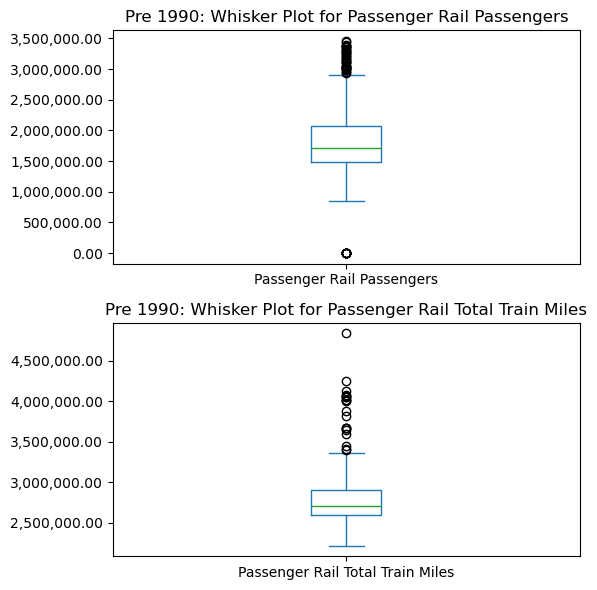


Pre 1990:


,Index,Date,Passenger Rail Passengers,Outliers Flagged Passenger Rail Passengers,Passenger Rail Total Train Miles,Outliers Flagged Passenger Rail Total Train Miles
336,336,1975-01-01,0.0,1,4134425.0,1
337,337,1975-02-01,0.0,1,3600736.0,1
338,338,1975-03-01,0.0,1,4067192.0,0
339,339,1975-04-01,0.0,1,4000157.0,1
340,340,1975-05-01,0.0,1,4050197.0,0


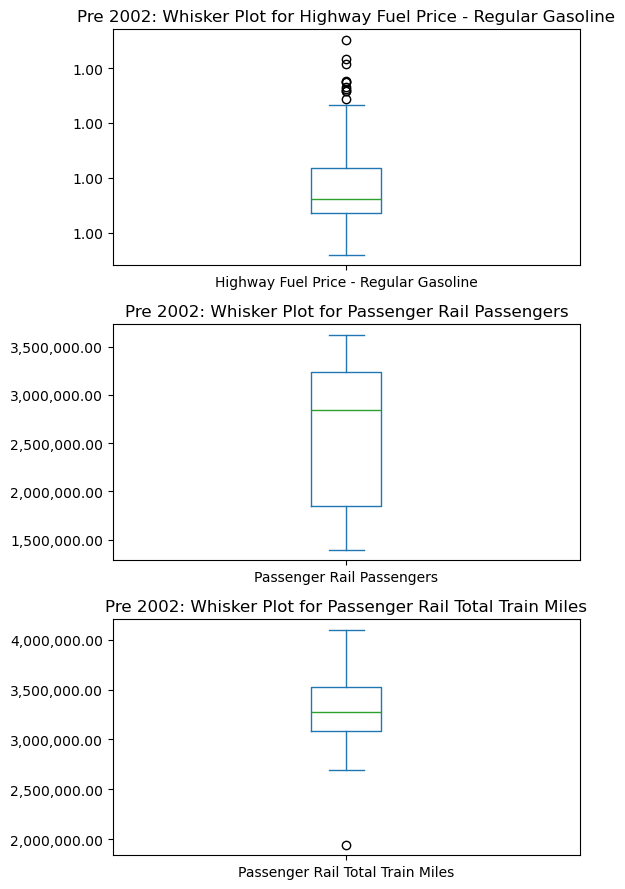


Pre 2002:


,Index,Date,Highway Fuel Price - Regular Gasoline,Outliers Flagged Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Outliers Flagged Passenger Rail Passengers,Passenger Rail Total Train Miles,Outliers Flagged Passenger Rail Total Train Miles
524,524,1990-09-01,1.258,0,3073787.0,0,3269824.0,0
525,525,1990-10-01,1.335,1,3291394.0,0,3613612.0,0
526,526,1990-11-01,1.324,0,3181611.0,0,3356131.0,0
527,527,1990-12-01,1.324,0,3023138.0,0,3395859.0,0
528,528,1991-01-01,1.324,0,3097361.0,0,3174949.0,0


ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

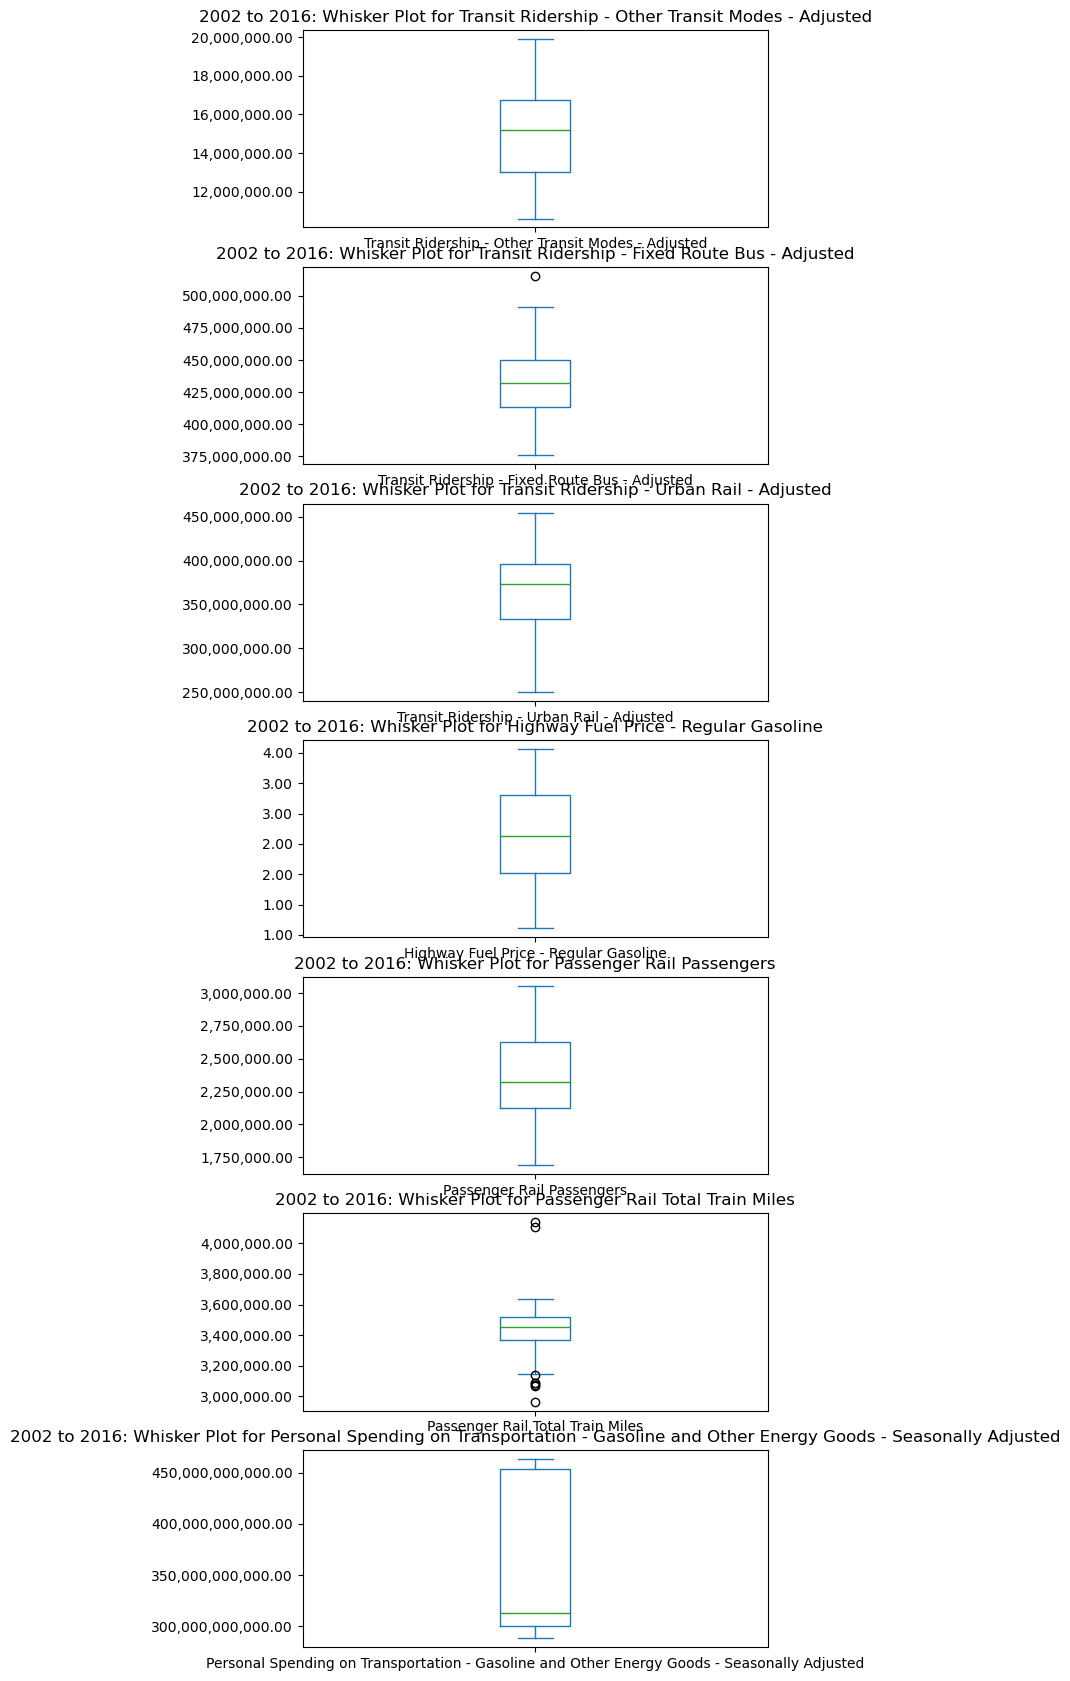

In [130]:
df_list = [df_pre1990, df_pre2002, df_2002_2016, df_post2016]
df_names = ["Pre 1990", "Pre 2002", "2002 to 2016", "Post 2016"]
updated_dfs = []
#Looping through lists containing all the datafarmes and creating a whisker plot for each column of each  dataframe
for df_name, df in zip(df_names, df_list):

  columns_plot = [col for col in df.columns[2:] if isinstance(col, str) and not col.startswith("Outliers")]

  fig, axes = plt.subplots(nrows=len(columns_plot), ncols=1, figsize=(6,3 * len(columns_plot)))
  if len(columns_plot)==1:
    axes = [axes]

  for ax, column in zip(axes,columns_plot):
    df[column].plot.box(ax=ax)
    ax.set_title(f"{df_name}: Whisker Plot for {column}")
    ax.ticklabel_format(style="plain", axis="y")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _:  f"{int(x):,.2f}"))

    #Added Isolation Forest for Outlier Detection
    iso_forest = IsolationForest(contamination=0.1, random_state=43)
    predictions = iso_forest.fit_predict(df[[column]])

    #Created a outlier flagging column for each respective column of each dataframe.
    flag_title = f"Outliers Flagged {column}"
    df[flag_title] = (predictions == -1).astype(int)
    columns = list(df.columns)
    if flag_title in columns:
      columns.remove(flag_title)
      index = columns.index(column)
      columns.insert(index + 1, flag_title)
      df = df[columns]

  plt.tight_layout()
  plt.show()

  print(f"\n{df_name}:")
  display(df.head())
  updated_dfs.append(df)

#Updated the dataframes to include the flagging column
df_pre1990, df_pre2002, df_2002_2016, df_post2016 = updated_dfs

We identified the outliers for each column of each dataframe and then flagged the outliers by using IsolationForest. IsolationForest is an algorithm that is used for anomaly detection to detect anomalies that are outliers. Then the outliers were displayed in their own respective flagging columns that are placed to the right of the columns each flagging column corresponds with. The outliers are given a one while non-outliers are given the default zero.


This link is great for those who want a deeper dive into the [IsolationForest algorithm](https://cran.r-project.org/web/packages/isotree/vignettes/An_Introduction_to_Isolation_Forests.html). For those who just want a basic understanding, check this out: [IsolationForest basics](https://www.geeksforgeeks.org/machine-learning/what-is-isolation-forest/).


The purpose of flagging outliers is so that we can currently obtain information on the extreme values in each respective era. With this information, we will be able to determine what period or even year was considered an anomaly when compared to other eras. Determining on a global level what is considered an anomaly based on the value's extremity is crucial for our data exploration and preprocessing stage because it allows us to determine the fate of these values later on.


## **Hypothesis Testing/ Exploratory Data Analytics**

*Test 1: Mann-Whitney U Test*  



At Significance level of α = 0.05
Null Hypothesis: There is no difference between the amount of rail passengers and the amount of bus passengers.  
Alternative Hypothesis: There are significantly more bus passengers than rail passengers.

In [131]:
#Setting up the Mann-Whitney U Test
stats, pval = mannwhitneyu(transit_df.iloc[:, [2]], transit_df.iloc[:, [ 3]])
print("P-value for Mann-Whitney U: ", pval)

P-value for Mann-Whitney U:  [4.61525205e-25]


Conclusion: Since the p-value returned is less than .05, we reject the null hypothesis. There is a signficantly more amount of passengers that prefer to use buses than rail.  Rail usage might be more expensive and less accessable. Meaning gas prices will not have the same effect on railways and buses.

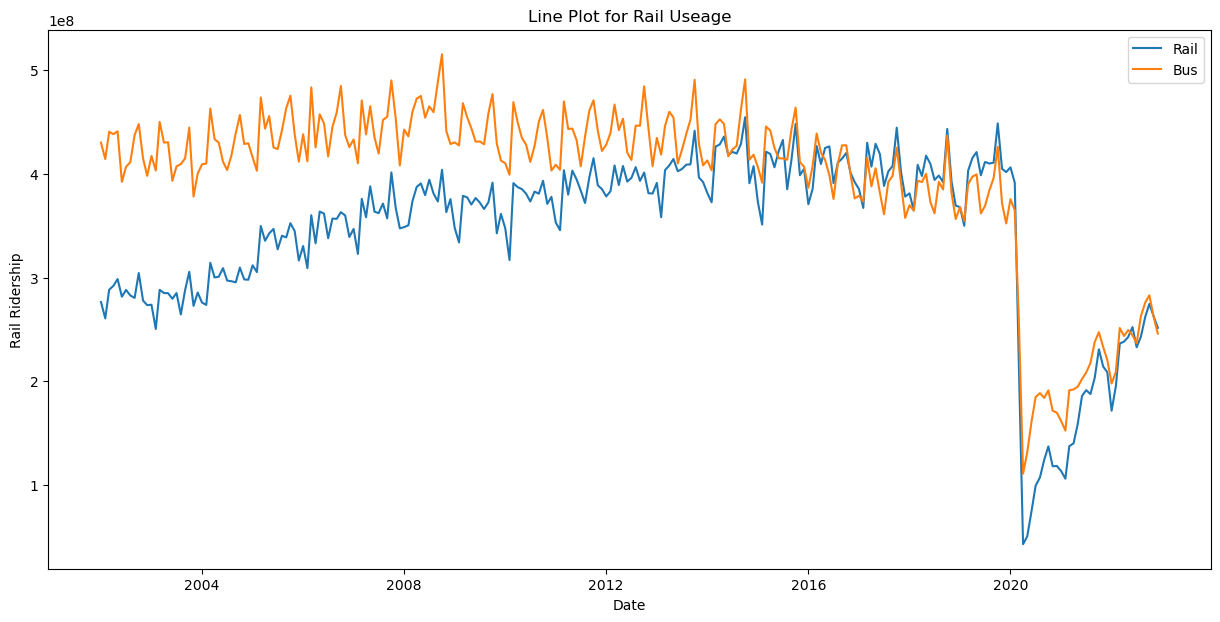

In [132]:
#Plotting
plt.figure(figsize=(15,7))
plt.plot(transit_df['Date'], transit_df['Transit Ridership - Urban Rail - Adjusted'], label = 'Rail')
plt.plot(transit_df['Date'], transit_df['Transit Ridership - Fixed Route Bus - Adjusted'], label = 'Bus')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Rail Ridership')
plt.title('Line Plot for Rail Useage')
plt.show()

This graph indicates the predominant usage of passengers preferring bus over rail. This shows that buses have more of an impact than rail when considering the impacts of gasprices.

*Test 2: ANOVA Test*

At a significance level of 95% , α = 0.05  
Null Hypothesis: There is no difference in Transit ridership when the gas prices are low/medium/high.  
Alternative Hypthesis: There is a difference between transit ridership when the gas prices are low/medium/high.

First we need to set up the data to use the ANOVA Test.

In [133]:
#Creating fresh dataframes and setting up the dataframe from the CSV file.
gasprices_b_df = pd.read_csv('USGasanddieselprices.csv')
transportation_b_df = pd.read_csv('Monthly_Transportation_Statistics.csv')

#Sellecting desirable columns.
gasprices_b_df = gasprices_b_df[['Date','A1']]
transportation_b_df = transportation_df[['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']]

#converting to Datetime Object.
gasprices_b_df['Date'] = pd.to_datetime(gasprices_b_df['Date'])
transportation_b_df['Date'] = pd.to_datetime(transportation_b_df['Date'])

#Limiting the range of the data to align the dataframes.
gasprices_b_df = gasprices_b_df[gasprices_b_df['Date'] >= '2002-01-01']
gasprices_b_df = gasprices_b_df[gasprices_b_df['Date'] <= '2021-01-04']
transportation_b_df = transportation_b_df.loc[transportation_df['Date'] >= '2002-01-01']
transportation_b_df = transportation_b_df.loc[transportation_b_df['Date'] <= '2021-01-01']

The "Transit Ridership - Urban Rail - Adjusted" column from the transportation_b_df will be dropped due to it not having as much of an impact with regards to Transit Ridership as a whole. This was proven in the Mann-Whitney U test which rejected the null hypothesis of there being no difference in the passenger ridership of rail and bus.

In [134]:
#It groups the gasprices dataframe from weekly to montly.
gasprices_month_df = gasprices_b_df.groupby(pd.Grouper( key = 'Date', freq = 'ME')).agg({'A1': 'mean'}).reset_index()

#Setting the range to determine what is considered a low, medium, and high gasprice.
low_gasprices = gasprices_month_df[gasprices_month_df['A1'] < 1.5]
medium_gasprices = gasprices_month_df[(gasprices_month_df['A1'] >= 1.5) & (gasprices_month_df['A1'] <= 2.3)]
high_gasprices = gasprices_month_df[gasprices_month_df['A1'] > 2.3]

#A new dataframe without the transit urban rail.
total_transit_ridership = transportation_b_df[['Date', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted']]

#A new column where all ridership except urban rail is included.
total_transit_ridership['Total Transit Ridership'] = total_transit_ridership[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted']].sum(axis = 1)
total_transit_ridership = total_transit_ridership.drop(total_transit_ridership[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted']], axis = 1)

#Converting total_transit_ridership, low_gasprices, medium_gasprices, and high_gasprices to a yyyy-mm basis so that they can be matched.
total_transit_ridership['YearMonth'] = total_transit_ridership['Date'].dt.strftime('%Y-%m') #yyyy-mm
low_gasprices['YearMonth'] = low_gasprices['Date'].dt.strftime('%Y-%m')
medium_gasprices['YearMonth'] = medium_gasprices['Date'].dt.strftime('%Y-%m')
high_gasprices['YearMonth'] = high_gasprices['Date'].dt.strftime('%Y-%m')

#Filtering out the transit ridership based on the gas price labels, low, medium, high.
low_merge = pd.merge(low_gasprices, total_transit_ridership, on = 'YearMonth', how = 'inner')
medium_merge = pd.merge(medium_gasprices, total_transit_ridership, on = 'YearMonth', how = 'inner')
high_merge = pd.merge(high_gasprices, total_transit_ridership, on = 'YearMonth', how = 'inner')

#extracting only the Transit ridership.
low_riders = low_merge['Total Transit Ridership']
medium_riders = medium_merge['Total Transit Ridership']
high_riders = high_merge['Total Transit Ridership']

#ANOVA Test
f_stat, p_val = f_oneway(low_riders, medium_riders, high_riders)
print(f"ANOVA Test results: \nF =  {f_stat:.2f}, p = {p_val:.2f}")

ANOVA Test results: 
F =  9.82, p = 0.00


Conclusion: The ANOVA Test results indicate that there is a difference in transit ridership depending on the price of gas. What this means is that gas prices may have an effect on transit ridership or may indicate that there are other related factors that affect transit ridership. A p-value of close to 0 indicates that we reject the null hypothesis since p-value of close to 0 <= 0.05 = α

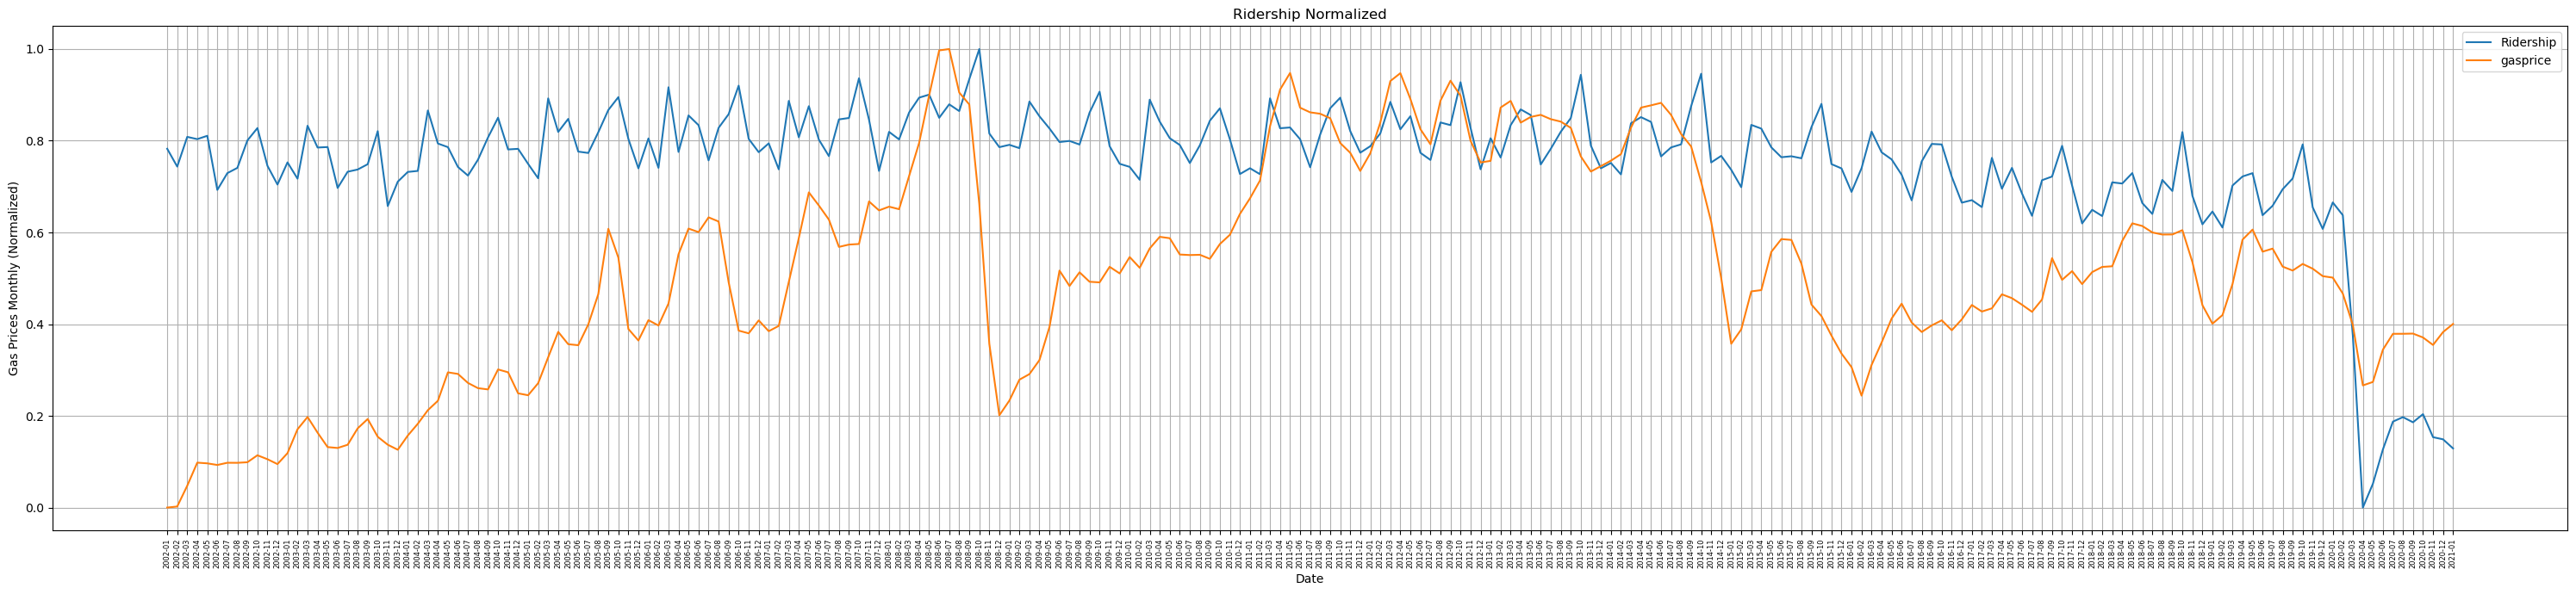

In [135]:
#Converting the date format to yyyy-mm
gasprices_month_df['YearMonth'] = gasprices_month_df['Date'].dt.strftime("%Y-%m")

#Dropping the original Date columns
gasprices_month_df = gasprices_month_df.drop(columns = ['Date'])
total_transit_ridership = total_transit_ridership.drop(columns = ['Date'])

#Normalizing the graph to visualize the difference between them
scaler = MinMaxScaler()
gasprices_month_df['A1 Normalized'] = scaler.fit_transform(gasprices_month_df[['A1']])
total_transit_ridership['Ridership Normalized'] = scaler.fit_transform(total_transit_ridership[['Total Transit Ridership']])

#Plotting
plt.figure(figsize=(30,7))
plt.plot(total_transit_ridership['YearMonth'], total_transit_ridership['Ridership Normalized'], label = 'Ridership')
plt.plot(gasprices_month_df['YearMonth'], gasprices_month_df['A1 Normalized'], label = 'gasprice')
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Date')
plt.ylabel('Gas Prices Monthly (Normalized)')
plt.legend()
plt.grid(True)
plt.title('Ridership Normalized')
plt.tight_layout()
plt.show()


*Test 3: Tukey's Honest Significance Difference (HSD) Test*

*Since this is the Tukey's HSD Test, we will need three different Null Hypotheses and Alterantive Hypotheses*

Null Hypothesis: The average ridership for low, medium, and high gas prices are the same.  
1) Average of High gas prices = Average of Low gas prices  
2) Average of High gas prices = Average of Medium gas prices
3) Average of Low gas prices = Average of Medium gas prices

Alternative Hypothesis: The average ridership for low, medium, and high are not the same.  
1) Average of High gas prices $\neq$ Average of Low gas prices  
2) Average of High gas prices $\neq$ Average of Medium gas prices  
3) Average of Low gas prices $\neq$ Average of Medium gas prices

At Significance level of α = 0.05.

In [136]:
#Setting up the data for Tukey's HSD Test by grouping all the ridership by the gas prices.
all_ridership = pd.concat([low_merge['Total Transit Ridership'], medium_merge['Total Transit Ridership'], high_merge['Total Transit Ridership']])

#Labeling Low, Medium, High with their frequency in the dataframes. No need to take the average since Tukey's does it.
group_labels = (['Low'] * len(low_merge) + ['Medium'] * len(medium_merge) + ['High'] * len(high_merge)
)

#Tukey's test finds the average of the three labels and compares the differences between them. Also indicates whether we should reject the Null.
tukey_result = pairwise_tukeyhsd(endog=all_ridership, groups=group_labels, alpha=0.05)

# Print the result
print(tukey_result)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
group1 group2    meandiff    p-adj      lower          upper      reject
------------------------------------------------------------------------
  High    Low   -4720633.022 0.9641 -47990260.1244  38548994.0804  False
  High Medium -41522946.8956    0.0 -63694268.9495 -19351624.8416   True
   Low Medium -36802313.8736 0.1427 -82639577.4209   9034949.6738  False
------------------------------------------------------------------------


High Vs. Low is not statisticlally significant. Same with Low Vs. Medium. But Medium Vs. High is statistcally significant. We reject the second hypothesis, but fail to reject the rest.

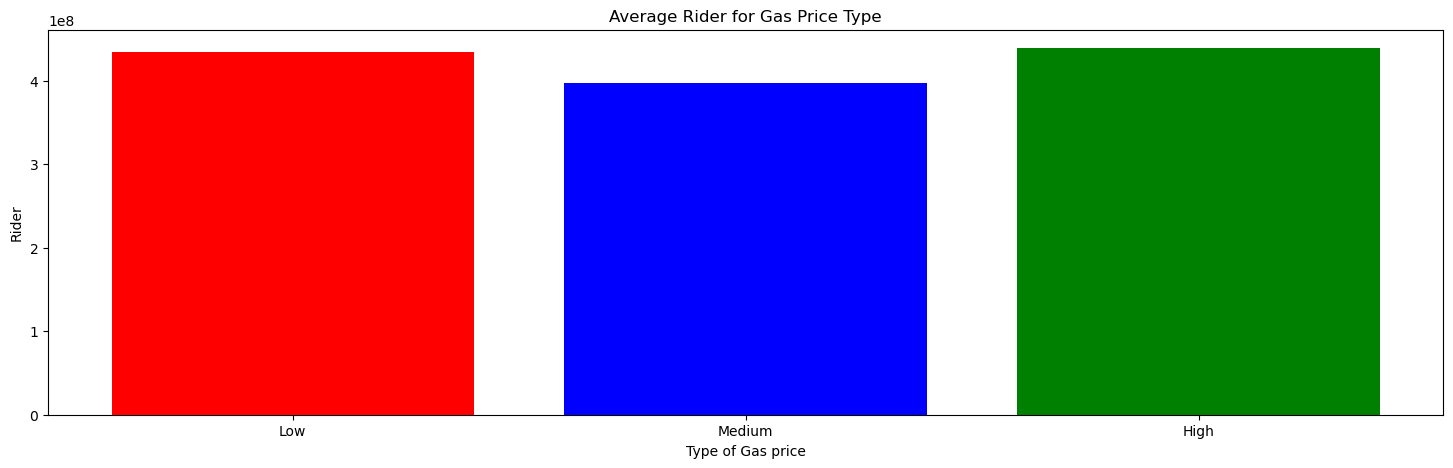

In [137]:
#Plotting a simple bar graph to visualize the differences in the means of all types of gas price ridership.
group = ['Low', 'Medium', 'High']
low_avg = low_merge['Total Transit Ridership'].mean()
medium_avg = medium_merge['Total Transit Ridership'].mean()
high_avg = high_merge['Total Transit Ridership'].mean()

avg = [low_avg, medium_avg, high_avg]

plt.figure(figsize=(18,5))
plt.bar(group, avg, color = ['red', 'blue', 'green'])
plt.xlabel
plt.title("Average Rider for Gas Price Type")
plt.xlabel('Type of Gas price')
plt.ylabel('Rider')
plt.show()

Conclusion: As demonstrated by Tukey's HSD and the Bar Chart, ridership is the lowest when gas prices is medium, which is \$1.5 to \$2.3. When gas prices are either too high or too low it means that there maybe external factors. A potential factors is the economy which prompts people to choose public transportation rather than their own cars. High gas prices means it is more expensive to drive a car, whereas low gas prices may indicate a recession or a loss of jobs.

Here, all the metrics of the transportation_df has been graphed to visualize the behavior and trends displayed by the data.

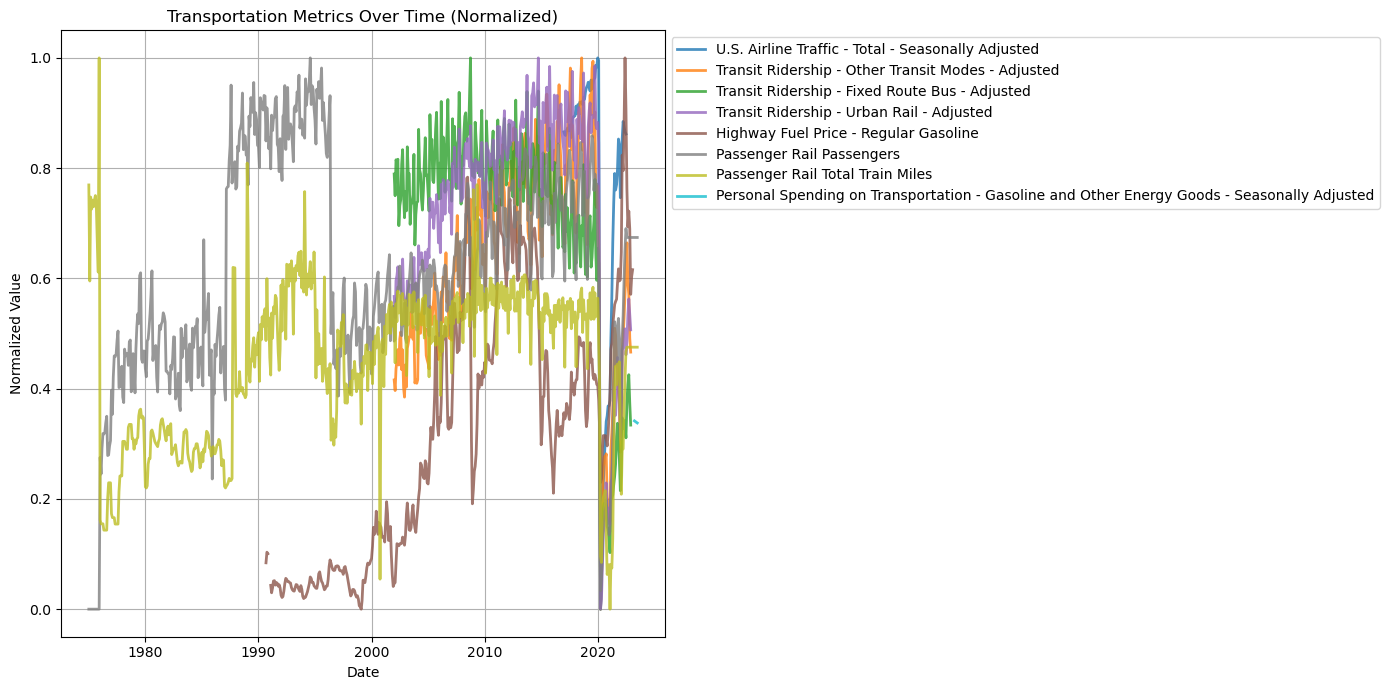

In [138]:
#Creating a fresh dataframe
transportation_b_df = transportation_b_df[transportation_b_df['Date'] >= '2002-01-01']
#Choosing the required columns
transportation_columns = ['U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted'
]

for col in transportation_columns:
    transportation_df[col] = pd.to_numeric(transportation_df[col], errors='coerce')

#Scaling the dataframe
scaler = MinMaxScaler()
transportation_df[transportation_columns] = scaler.fit_transform(transportation_df[transportation_columns])

#Plotting the dataframe with different colors to visualize
plt.figure(figsize=(14, 7))
colors = plt.cm.get_cmap('tab10', len(transportation_columns))\

for i, col in enumerate(transportation_columns):
    plt.plot(transportation_df['Date'], transportation_df[col], label=col, color=colors(i), linewidth=2, alpha=0.8)

plt.title("Transportation Metrics Over Time (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

As you can see the multiple graphs overlapping each other making it unrecognizable. As such, dropping columns such as Personal Spending on Transportation and Highway Fuel Price can be dropped. It is also better to group some of the columns which share similaritie such as the Transit columns and the Passenger columns.

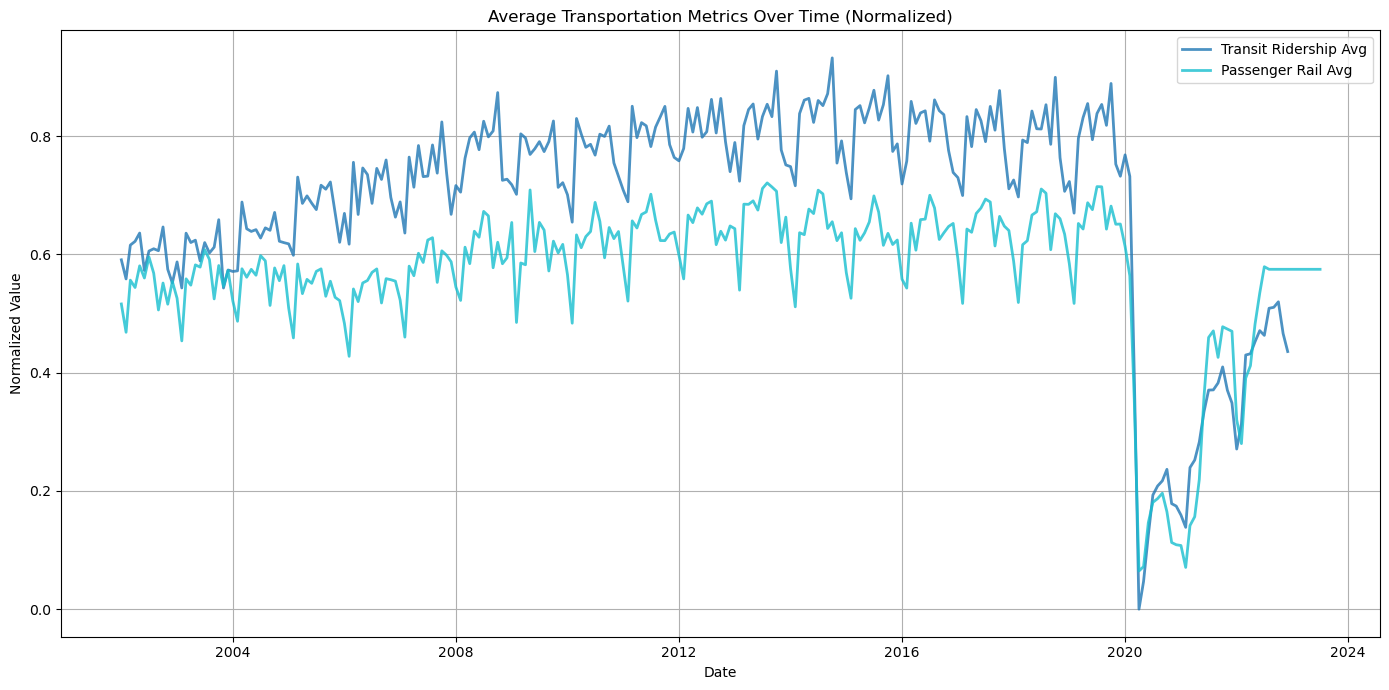

In [139]:
#Setting up the data
transportation_df['Transit Ridership Avg'] = transportation_df[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']].mean(axis = 1)
transportation_df['Passenger Rail Avg'] = transportation_df[['Passenger Rail Passengers', 'Passenger Rail Total Train Miles']].mean(axis = 1)
transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])
transportation_df = transportation_df[transportation_df['Date'] >= '2002-01-01']
transportation_avg_df = transportation_df[['Date', 'Transit Ridership Avg', 'Passenger Rail Avg']]
transportation_avg_columns = ['Transit Ridership Avg','Passenger Rail Avg',]

#Plotting the graph
for col in transportation_avg_columns:
    transportation_avg_df[col] = pd.to_numeric(transportation_avg_df[col], errors='coerce')

plt.figure(figsize=(14, 7))
colors = plt.cm.get_cmap('tab10', len(transportation_avg_columns))

for i, col in enumerate(transportation_avg_columns):
    plt.plot(transportation_avg_df['Date'], transportation_avg_df[col], label=col, color=colors(i), linewidth=2, alpha=0.8)

plt.title("Average Transportation Metrics Over Time (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Combined columns regarding tarnsit into one by taking their average. Same is done for passengers on rail. This was done to reduce the number of plots in total and to get a general idea of transit and passengers on rail. All other columns are left as original. For both dataframes, intersection of the core of data begins from 2002. Hence, both dataframe's timeline begins at 2002.In addition, normalization allows for both dataframes to be compared and to improve visualization.

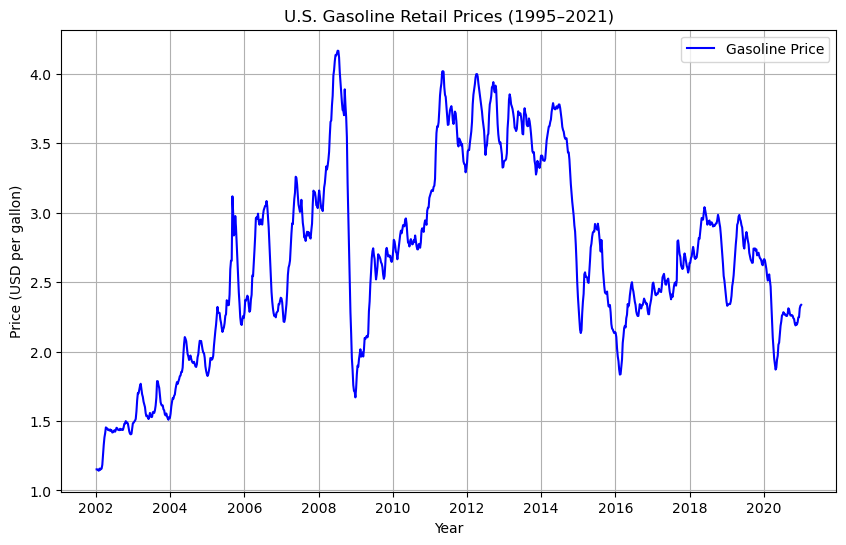

In [140]:
#Setting the data and limiting the gas prices to the desirable range
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
gasprices_df = gasprices_df[gasprices_df['Date'] >= '2002-01-01']

#Plotting the gas prices
plt.figure(figsize=(10, 6))
plt.plot(gasprices_b_df['Date'], gasprices_b_df['A1'], label='Gasoline Price', color='blue')
plt.grid(True)
plt.title('U.S. Gasoline Retail Prices (1995–2021)')
plt.xlabel('Year')
plt.ylabel('Price (USD per gallon)')
plt.legend()

## **Machine Learning Model**
<h5> Here we will try to find a machine learning model that can predict gas prices based on parameters passed in.

Our previous parts focused on identifying what datasets we were going to use, cleaning up and preprocessing them, and then conducting tests to either support or reject our null hypotheses. Based on our previous work, we have assumed that there is a relationship between gas prices, the dependent variable, and the transit stats we are using as our independent variables. The objective of our Machine Learning section is to utilize appropriate models to identify the strength and proportionality of the relationship between gas prices and other transit stats.

We will use total_df defined in the cleaning and preprocessing step, this lets us use gas prices which is in months just like our transportation metrics

In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
'''
#Load in dataframes
transportation_df = pd.read_csv('Monthly_Transportation_Statistics.csv')
gasprices_df = pd.read_csv('USGasanddieselprices.csv')

#Convert to datetime object
transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])

#Choosing the single column of gas prices
gasprices_df = gasprices_df[['Date', 'A1']]

#Renaming the gas prices dataframe's columns
gasprices_df.rename(columns = {"A1": "Weekly Retail Gasoline Prices(All Grades Formulation)"}, inplace=True)
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])

#Setting index to date and groups the gas prices to months
gasprices_df = gasprices_df.groupby(pd.Grouper( key = 'Date', freq = 'ME')).agg({"Weekly Retail Gasoline Prices(All Grades Formulation)": 'mean'}).reset_index()
gasprices_df.set_index('Date', inplace = True)
transportation_df.set_index('Date', inplace = True)

#Merges the two dataframes.
transportation_df.index = transportation_df.index.to_period('M')
gasprices_df.index = gasprices_df.index.to_period('M')
total_df = pd.merge( transportation_df, gasprices_df, on ='Date', how = 'outer')
#total_df['Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted'] = total_df['Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted'].ffill()
display(total_df.head())
'''

'\n#Load in dataframes\ntransportation_df = pd.read_csv(\'Monthly_Transportation_Statistics.csv\')\ngasprices_df = pd.read_csv(\'USGasanddieselprices.csv\')\n\n#Convert to datetime object\ntransportation_df[\'Date\'] = pd.to_datetime(transportation_df[\'Date\'])\ngasprices_df[\'Date\'] = pd.to_datetime(gasprices_df[\'Date\'])\n\n#Choosing the single column of gas prices\ngasprices_df = gasprices_df[[\'Date\', \'A1\']]\n\n#Renaming the gas prices dataframe\'s columns\ngasprices_df.rename(columns = {"A1": "Weekly Retail Gasoline Prices(All Grades Formulation)"}, inplace=True)\ngasprices_df[\'Date\'] = pd.to_datetime(gasprices_df[\'Date\'])\n\n#Setting index to date and groups the gas prices to months\ngasprices_df = gasprices_df.groupby(pd.Grouper( key = \'Date\', freq = \'ME\')).agg({"Weekly Retail Gasoline Prices(All Grades Formulation)": \'mean\'}).reset_index()\ngasprices_df.set_index(\'Date\', inplace = True)\ntransportation_df.set_index(\'Date\', inplace = True)\n\n#Merges the two 

Next, let's see how skewed our data is. This will help us determine if there are imbalances in our data. To visualize the skewedness, we have decided to utilize histograms so that we can see the different proportions that make up each independent variable.

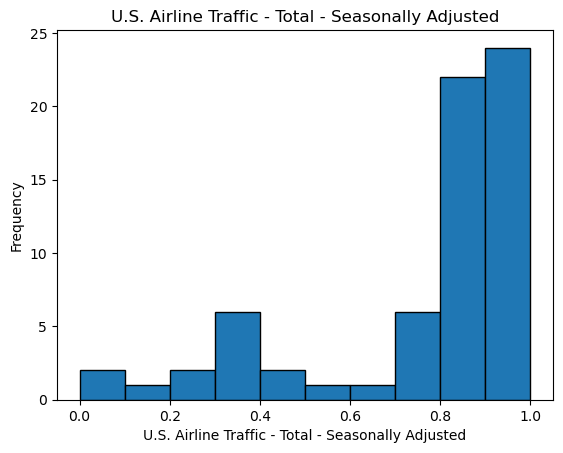

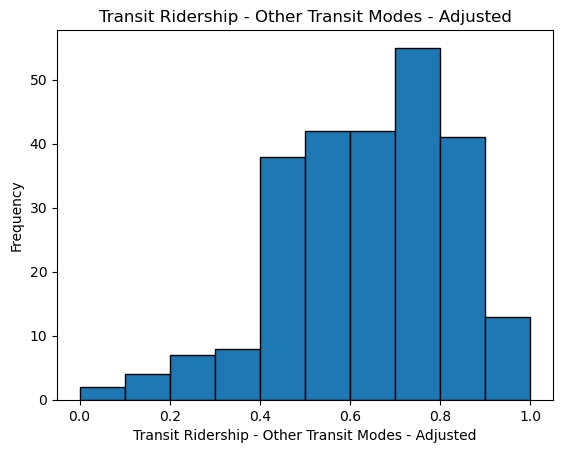

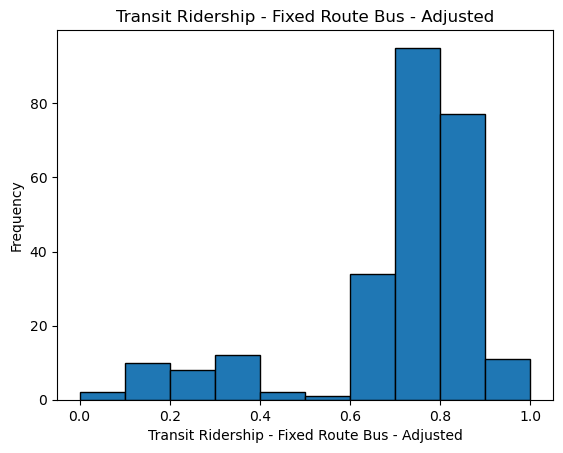

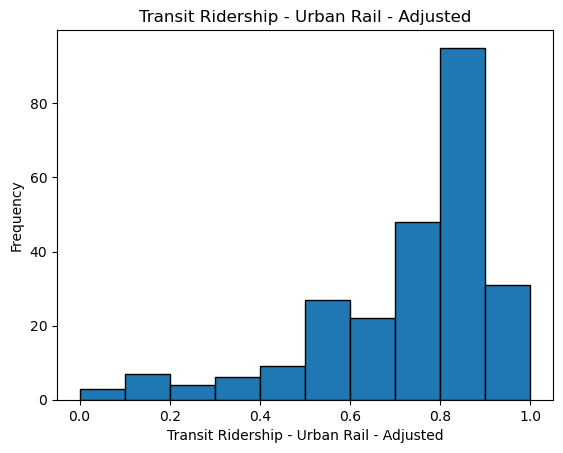

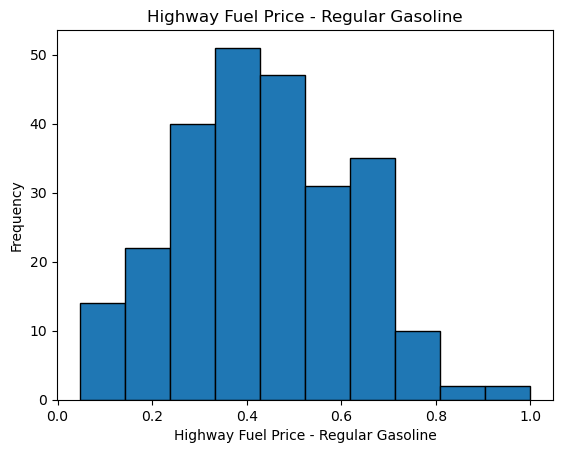

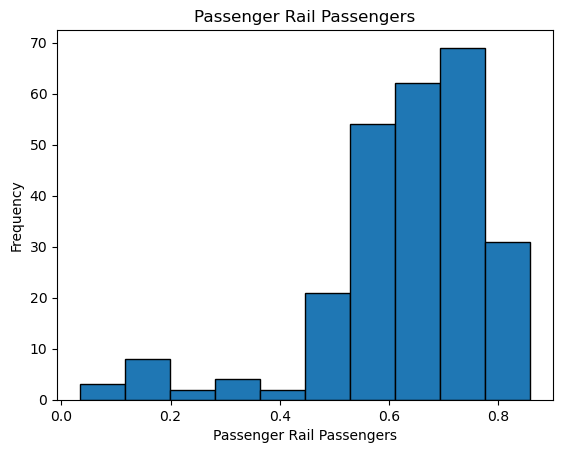

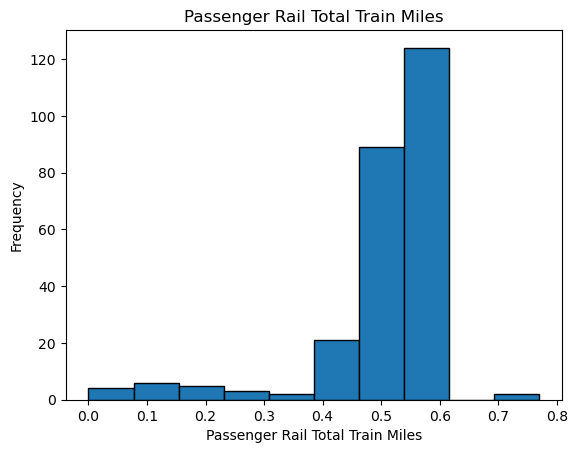

In [142]:
hist_df = transportation_df[['U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles']]
for element in hist_df.columns:
    plt.figure()
    hist_df[element].hist(bins = 10, edgecolor='black')
    plt.title(element)
    plt.xlabel(element)
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.show()

Our histograms show that it has a diverse range of numbers with varying frequency values. It is clear that due to the sizable Differences in frequencies, the data is Skewedskewed. The histograms with the most skewed data are the US Airline Traffic Total, Transit Ridership Fixed Route Bus, Transit Ridership Urban Rail, and Highway Fuel Price. Skewed data can cause high bias during model training, in which the model may consistently predict specific gas prices due to the larger influence some values in our independent variables may have. In this case, the most skewed independent variables will strongly influence our model’s prediction of the gas price.
In order to tackle this issue, we have decided to use Log Scaling to help compress very large values and spread out very small values so that our data is closer to a bell-shaped curve, which is very similar to a normal distribution. After applying log scaling, we decided to apply standard scaling because different features may have different scales. Some values may have different maximum values and minimum values, so to ensure each feature is treated fairly, we apply standard scaling where each feature’s values are zero-centered, where the mean is zero and the standard deviation is one.


In [143]:
#Getting the timeframe where there isn't any NaNs
withoutdate_df = total_df[total_df.index >='2017-01']
withoutdate_df = withoutdate_df[withoutdate_df.index <= '2021-01']
withoutdate_df = withoutdate_df[['U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted',  'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Weekly Retail Gasoline Prices(All Grades Formulation)']]

#Defining X and Y
X = withoutdate_df[['U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles']]
Y = withoutdate_df[['Weekly Retail Gasoline Prices(All Grades Formulation)']]

#Applying Log scaling to X and Y
X = np.log(X)
Y = np.log(Y)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Linear regression models are used for numerical values, in our case, both the features and output are numerical. This type of model attempts to find a linear relationship between the input and the output. In our case, we want to see if our transportation statistics can form a linear relationship with gas prices.


In [144]:
#Linear Model
np.random.seed(42)
model = make_pipeline(StandardScaler(), LinearRegression())

model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_train = model.predict(X_train)
training_mse_lrm = mean_squared_error(y_train, pred_train)
validation_mse_lrm = mean_squared_error(y_test, pred)
print(f"Training MSE(Mean Squared Error): {training_mse_lrm}")
print(f"Validation MSE(Mean Squared Error): {validation_mse_lrm}")
r_score = r2_score(y_test, pred)
print(f"Validation R^2 score: {r_score}")

Training MSE(Mean Squared Error): 0.003126072463008299
Validation MSE(Mean Squared Error): 0.00247199475013164
Validation R^2 score: 0.7686160981201605


This model is okay, however we will try more intricate models below to see if we can do better

Polynomial regression models, just like linear regression models, are used for numerical values. However, unlike linear regression models, this model tries to find a polynomial relationship between features, meaning it graphs things like x^2, x^3, etc… As shown in the hypothesis testing, our data is not very linear, so we believe this model will work better.

In [145]:
#Polynomial Model
poly = PolynomialFeatures(degree = 2)
linear = LinearRegression()
model = make_pipeline(poly, StandardScaler(), linear)
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_train = model.predict(X_train)
training_mse_prm = mean_squared_error(y_train, pred_train)
validation_mse_prm = mean_squared_error(y_test, pred)
print(f"Training MSE(Mean Squared Error): {training_mse_prm}")
print(f"Validation MSE(Mean Squared Error): {validation_mse_prm}")
r_score = r2_score(y_test, pred)
print(f"Validation R^2 score: {r_score}")

Training MSE(Mean Squared Error): 0.00026825861405071355
Validation MSE(Mean Squared Error): 0.6761507418129604
Validation R^2 score: -62.289129918782926


This model is very inferior to the previous model. We will try a random forest model next.

Random forest models can be used for both categorical and numerical data. The way these work is by creating many decision trees using bootstrapping to find the optimal output value. (Look at link for decision trees).
Comments for all code and documentation on all code


In [146]:
#Random Forest Model
random = make_pipeline(StandardScaler(), RandomForestRegressor(random_state = 42))

random.fit(X_train, y_train)
pred = random.predict(X_test)
pred_train = random.predict(X_train)
training_mse_rf = mean_squared_error(y_train, pred_train)
validation_mse_rf = mean_squared_error(y_test, pred)
print(f"Training MSE(Mean Squared Error): {training_mse_rf}")
print(f"Validation MSE(Mean Squared Error): {validation_mse_rf}")
r_score = r2_score(y_test, pred)
print(f"Validation R^2 score: {r_score}")

Training MSE(Mean Squared Error): 0.00029051687467134533
Validation MSE(Mean Squared Error): 0.00215390551290036
Validation R^2 score: 0.7983899189798674


This model performs the best so far.

In [147]:
#Neural Networks

# Creates a multi-layer perceptron regressor where the ReLU activation function is used.
mlp = MLPRegressor(hidden_layer_sizes=(150, 75, 37), activation='relu', alpha=1e-5, max_iter=10000, random_state=42) 

# Creates a pipeline which scales the data using StandardScalar
pipe_mlp = make_pipeline(StandardScaler(), mlp)

#Performs k-fold cross validation with k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = cross_val_score(pipe_mlp, X_train, y_train.values.ravel(), cv=kf, scoring='r2')


print("MLP  R2 mean:", np.round(r2.mean(), 3))

#Training the model and getting the predictions
pipe_mlp.fit(X_train, y_train.values.ravel())
y_pred = pipe_mlp.predict(X_test)
pred_train = pipe_mlp.predict(X_train)
training_mse_mlpwa = mean_squared_error(y_train, pred_train)
validation_mse_mlpwa = mean_squared_error(y_test, y_pred)

print("MSE: ",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

MLP  R2 mean: -2.024
MSE:  0.020197332218789825
R2 -0.8905127270590354


While the linear and random forest models give acceptable results, the polynomial and neural network is terrible. One thing that might be causing this is lack to data, in order to get more we should remove airline usage as it has mostly NaN values from 2002 to 2017.
Lets try without using airline usage so that we can start at 2002

In [148]:
#Choosing new time period
withoutdate_df = total_df[total_df.index >= '2002-01']
withoutdate_df = withoutdate_df[withoutdate_df.index <= '2021-01']
withoutdate_df = withoutdate_df[[ 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted',  'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Weekly Retail Gasoline Prices(All Grades Formulation)']]

#Defining X and Y
X = withoutdate_df[[ 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles']]
Y = withoutdate_df[['Weekly Retail Gasoline Prices(All Grades Formulation)']]

#Log scaling X and Y
X = np.log(X)
Y = np.log(Y)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Linear regression model- without airline

In [149]:
#Linear Regression
np.random.seed(42)
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_train = model.predict(X_train)
training_mse_lrmwa = mean_squared_error(y_train, pred_train)
validation_mse_lrmwa = mean_squared_error(y_test, pred)
print(f"Training MSE(Mean Squared Error): {training_mse_lrmwa}")
print(f"Validation MSE(Mean Squared Error): {validation_mse_lrmwa}")
r_score = r2_score(y_test, pred)
print(f"Validation R^2 score: {r_score}")

Training MSE(Mean Squared Error): 0.043717749833453674
Validation MSE(Mean Squared Error): 0.038520056095999955
Validation R^2 score: 0.454519469218606


This model is pretty bad, but to be sure we must try other models without airline data as well

Polynomial without airline

In [150]:
#Polynomial Regression
poly = PolynomialFeatures(degree = 2)
linear = LinearRegression()
model = make_pipeline(StandardScaler(), poly, linear)
model.fit(X_train, y_train)


prediction_poly = model.predict(X_test)
pred_train = model.predict(X_train)

training_mse_pwa = mean_squared_error(y_train, pred_train)
validation_mse_pwa = mean_squared_error(y_test, prediction_poly)
print(f"Training MSE(Mean Squared Error): {training_mse_pwa}")
print(f"Validation MSE(Mean Squared Error): {validation_mse_pwa}")
r_score = r2_score(y_test, prediction_poly)
print(f"Validation R^2 score: {r_score}")

Training MSE(Mean Squared Error): 0.018177315846888472
Validation MSE(Mean Squared Error): 0.015939599893319497
Validation R^2 score: 0.7742801467219602


This model is pretty good, we will try a random forest one one last time

Random Forest, no airine

In [151]:
#Random Forest Regression
random = make_pipeline(StandardScaler(), RandomForestRegressor(random_state = 42))
random.fit(X_train, y_train)
pred = random.predict(X_test)
pred_train = random.predict(X_train)

training_mse_rfwa = mean_squared_error(y_train, pred_train)
validation_mse_rfwa = mean_squared_error(y_test, pred)
print(f"Training MSE(Mean Squared Error): {training_mse_rfwa}")
print(f"Validation MSE(Mean Squared Error): {validation_mse_rfwa}")
r_score = r2_score(y_test, pred)
print(f"Validation R^2 score: {r_score}")

Training MSE(Mean Squared Error): 0.0031688582605115326
Validation MSE(Mean Squared Error): 0.01972517380836138
Validation R^2 score: 0.7206728294495517


Lastly, lets see if making a neural network gives us any better predictions than the machine learning models

In [152]:
# Creates a multi-layer perceptron regressor where the ReLU activation function is used.
mlp = MLPRegressor(hidden_layer_sizes=(150, 75, 37), activation='relu', alpha=1e-5, max_iter=10000, random_state=42) 

# Creates a pipeline which scales the data using StandardScalar
pipe_mlp = make_pipeline(StandardScaler(), mlp)

#Performs k-fold cross validation with k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2 = cross_val_score(pipe_mlp, X_train, y_train.values.ravel(), cv=kf, scoring='r2')


print("MLP  R2 mean:", np.round(r2.mean(), 3))

#Training the model and getting the predictions
pipe_mlp.fit(X_train, y_train.values.ravel())
y_pred = pipe_mlp.predict(X_test)
pred_train = pipe_mlp.predict(X_train)
training_mse_mlp = mean_squared_error(y_train, pred_train)
validation_mse_mlp = mean_squared_error(y_test, y_pred)

print("MSE: ",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

MLP  R2 mean: 0.687
MSE:  0.019736460554399652
R2 0.7205129984201157


The neural network seems to have a similar performance to that of the Random Forest model.

## **Model Analysis**

*Model Performance Metrics used for Model Analysis*

To determine whether a model's performance is good or bad, we look at two key performance metrics: MSE(Mean Squared Error) and R^2(R Squared) score. The low mean squared error and high R-squared score indicate that a model fits well with the data it has been trained on and also performs well on unseen data. To be more specific, a low mean squared error means that the mean squared error margin, which represents how far the predicted y values are from the actual y values, is low, indicating that the predicted values are very near the actual y values. A high R-squared value means that the model explains a large proportion of variance in the dependent variable, gas prices, which indicates a strong correlation between the independent variables and the dependent variable.


The low mean squared error and high R-squared score indicate that our model fits well with the data it has been trained on and also performs well on unseen data. The low mean-squared error value represents the error margin between the predicted y value and the actual y value. A lower error percentage means that our predicted y values are much closer to the actual y values. A high R-squared value means that a large proportion of the variance is captured by the dependent variable, the gas price, which also leads to the same conclusion our mean squared error made, which is that our predicted y values closely align with the actual y values.

*Linear Regression Analysis*

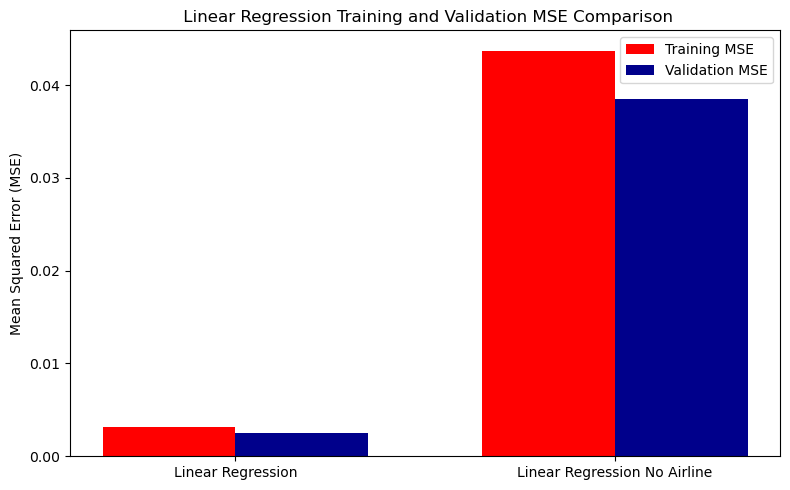

In [153]:
#Creating the labels for the model
labels = ['Linear Regression', 'Linear Regression No Airline']
training_mse_lr_values = [training_mse_lrm, training_mse_lrmwa]
validation_mse_lr_values = [validation_mse_lrm, validation_mse_lrmwa]

#X locations for the labels
x = np.arange(len(labels))
width = 0.35

#Plotting the data
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, training_mse_lr_values, width, label= 'Training MSE', color='Red')
bars2 = ax.bar(x + width/2, validation_mse_lr_values, width, label='Validation MSE', color='darkblue')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title(' Linear Regression Training and Validation MSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

Neither of the linear regression models performs as well as other models, as shown by the MSE and R2 values. Linear regression without the airline, in fact, shows a significant drop in R2, meaning that the airline feature brings in strong linearity and reduces the polynomial aspect of the rest of the data.

*Polynomial Regression Analysis*

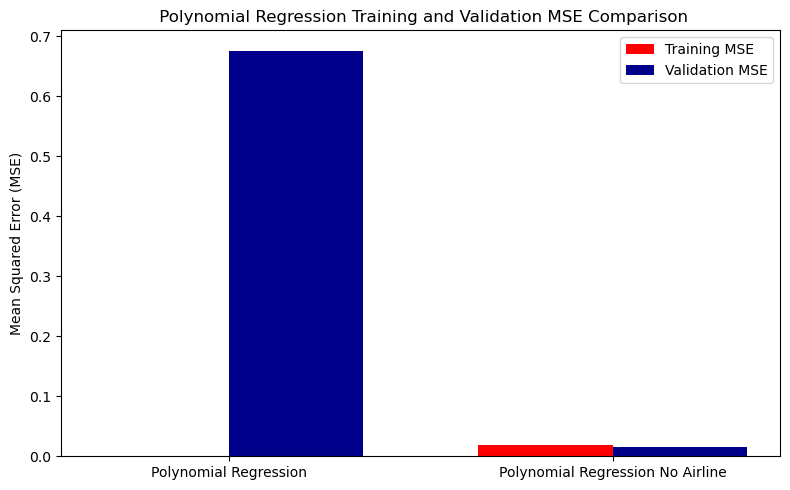

In [154]:
#Creating the labels for the model
labels = ['Polynomial Regression', 'Polynomial Regression No Airline']
training_mse_p_values = [training_mse_prm, training_mse_pwa]
validation_mse_p_values = [validation_mse_prm, validation_mse_pwa]

#X locations for the labels
x = np.arange(len(labels))
width = 0.35

#Plotting the data
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, training_mse_p_values, width, label= 'Training MSE', color='Red')
bars2 = ax.bar(x + width/2, validation_mse_p_values, width, label='Validation MSE', color='darkblue')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title(' Polynomial Regression Training and Validation MSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

Based on this information our best model is the polynomial without airline model. This is because not only is the MSE values for training and validation small but the difference between the two values is small which indicates that the model is not overfitted. It can generalize better with unseen data compared to training data. Also the R squared value is high which shows that the model explains a large proportion of variance in the dependent variable.


*Random Forest Analysis*

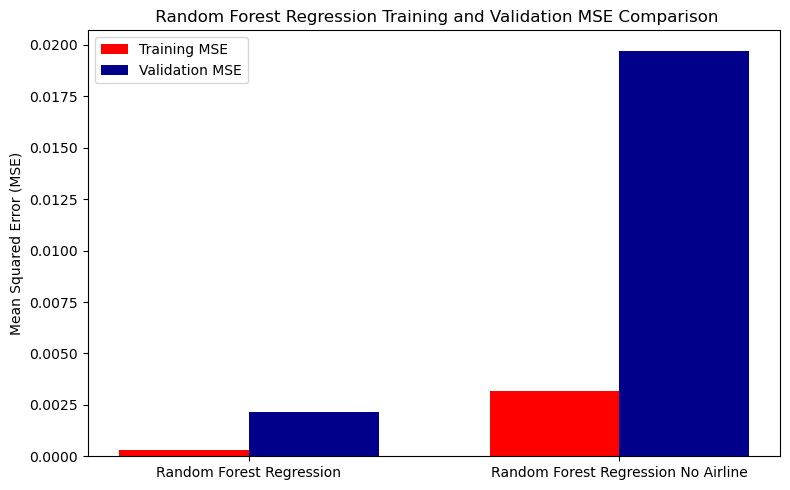

In [155]:
#Creating the labels for the model
labels = ['Random Forest Regression', 'Random Forest Regression No Airline']
training_mse_rf_values = [training_mse_rf, training_mse_rfwa]
validation_mse_rf_values = [validation_mse_rf, validation_mse_rfwa]

#X locations for the groups
x = np.arange(len(labels))
width = 0.35

#Plotting the data
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, training_mse_rf_values, width, label= 'Training MSE', color='red')
bars2 = ax.bar(x + width/2, validation_mse_rf_values, width, label='Validation MSE', color='darkblue')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title(' Random Forest Regression Training and Validation MSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


While the Random Forest model with the airline column has a higher R squared value and lower MSE, the trainig MSE is suspiciously low, and the difference between the training MSE and the Validation MSE is higher, indicating that the model is overfitting, thus polynomial without airline is the best. This makes sense as random forest is prone to overfitting when too many features are used. If we were to increase the number of trees, then it is likely it would overfit even more, decreasing the number of trees would likely cause the model to not perform as well on any data. Therefore, the polynomial without airline model is the best.

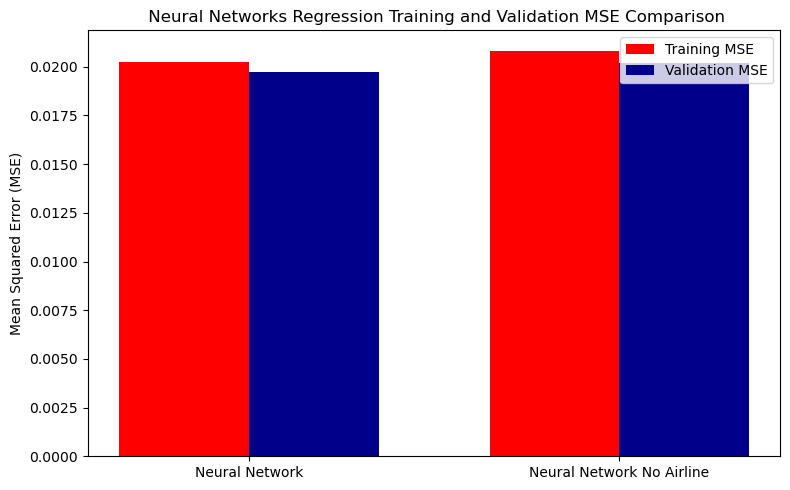

In [156]:
#Creating the labels for the model
labels = ['Neural Network', 'Neural Network No Airline']
training_mse_rf_values = [training_mse_mlp, training_mse_mlpwa]
validation_mse_rf_values = [validation_mse_mlp, validation_mse_mlpwa]

#X locations for the groups
x = np.arange(len(labels))
width = 0.35

#Plotting the data
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, training_mse_rf_values, width, label= 'Training MSE', color='red')
bars2 = ax.bar(x + width/2, validation_mse_rf_values, width, label='Validation MSE', color='darkblue')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title(' Neural Networks Regression Training and Validation MSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()

Although the MSE values for with and without airlines are the same, the R2 value for Neural Networks with airline is poor. This leads us to believe that this model is not as good as the Polynomial Regression model without airlines.

Neural Network Analysis

## **Model Visualization**

FIller - why we chose this graph

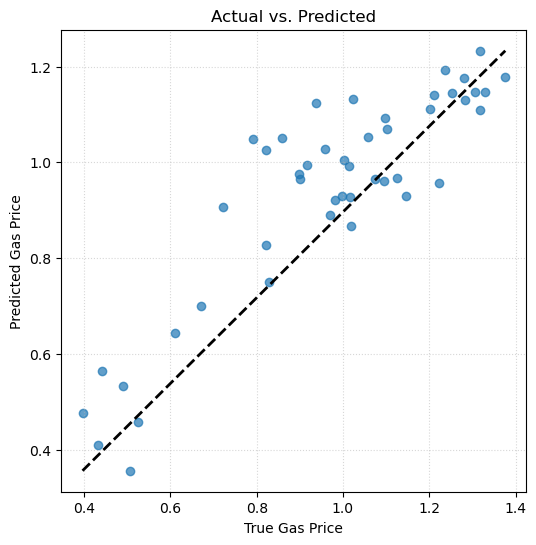

In [157]:
#Plotting the scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, prediction_poly, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [prediction_poly.min(), prediction_poly.max()], linestyle='--', color='k', linewidth=2)
plt.xlabel("True Gas Price")
plt.ylabel("Predicted Gas Price")
plt.title("Actual vs. Predicted")
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

This shows the predicted versus actual values for the polynomial regression model without the airline column. The closer a data point is to the dashed line, the closer it is to the actual value. This shows that the data points are really close to their actual values, but not exact, meaning there is no overfitting.

As shown in the graphs above, the differences in the mean squared error for randomforest show that there is likely overfitting with those modes. On the other hand, polynomial regression without airline has similar mean squared errors, meaning that the model is likely not overfitting.

## **Insights and Conclusions**

Overall we were able to make a model that predicts gas prices based on different transportation metrics. We discovered that our data was missing in different time frame blocks for different features, meaning it could not be imputed. On one hand, we set our time frame from 2017 to 2021 as this was the period where all of our chosen features had no NaNs. But this came at the cost of datapoints. Whereas on the other hand, we set our time frame from 2002 to 2021 as this was earliest time period where ⅞ of our chosen features had data. But this came at the cost of occasional NaNs. We weighed the benefits and in the end decided to use the longer time frame. This improved the accuracy of our models since more data would yield more accuracy. The shorter time frame was severely prone to overfitting. However, to improve our model, we decided to stop using Air Transportation usage as a feature since it did not have data for most of the time frame from 2002 to 2021. We accounted for data skewing by applying a log transformation to all data points. This led to us concluding that the polynomial regression model was the best.

Through hypothesis testing, we found that our initial idea that high gas prices led to high transportation usage was correct, however we also found that low gas prices also had high transit usage. Meaning that transit usage did have a correlation with gas prices, it just wasn’t the one we were expecting and was not easy to predict. Because of the complexity, a machine learning model was needed to explore if transportation metrics in general can be used to predict gas prices. Our results indicated that the relationship between them was non linear and depended on external factors.

This is significant because it proves there is a relationship between gas prices and different forms of transportation metrics. This also disproves our initial assumption, which was intuition that everyone could agree upon, that an increase in gas prices correlates to an increase in public transportation. Furthermore, gas prices, have a heavy correlation with the economy. What this means is that public transportation metrics, like bus and rail usage, can be used to determine the health of the economy. Overall, this project aims to discover the relationship between gas prices and transportation metrics. We found that the polynomial model best accomplishes this. This model’s high accuracy can be used to predict future relations as well.

**Helpful Links**

Metrics link for more depth(Beginner + Advanced)  
https://developer.nvidia.com/blog/a-comprehensive-overview-of-regression-evaluation-metrics/   
Random Forest Regressor for beginners to understand
https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/   
Random Forest for advanced learners to apply more advanced techniques   
https://medium.com/@saraswataroy21/mastering-random-forests-advanced-techniques-for-optimal-ensemble-learning-in-machine-learning-45e65b94b848   
More on Decision trees  
https://www.ibm.com/think/topics/decision-trees   
Gas price explanations  
https://www.rff.org/publications/explainers/gas-prices-101/